# Notebook 1: Building an Expected  Goals Model Using Random Forest

## Introduction:

<font color='black'> Welcome to my first notebook on expected goals models. In these notebooks, we will build on the excellent work already done by David Sumpter on the Friends of Tracking Series and @clekraus on his soccer_analytics Github repo, and take a deeper dive into the concepts, compare the pros and cons of simpler and more complex models, examine how we would calibrate our models, and generate plots that could be helpful for a coaching staff <font>

<font color='black'> In our first notebook on building expected goals models, we will look at building an Expected Goals Model using a Random Forest model. Random Forest models are generally the most widely known and simples model class in Machine Learning, and the concepts learned from building a Random Forest model translate when building other machine learning and deep learning models, such as a  LightGBM (which @clekraus uses in his notebook) or an xGBoost (which @DevinPleuler intends to release soon on his analytics-handbook Github repo). Random Forests are also notorious for not being well calibrated, which will come in handy during the notebook where we focus on calibrating our machine learning models. </font>

#### <font color='black'> In this notebook, we will place an emphasis on the following points:  <br>

 1.) The dangers of using the default sklearn parameters when training a Random Forest, particularly with regards to overfitting.<br> <br>
2.) Hyperparameter tuning and cross validation, comparing Grid Search and Random Search <br> <br>
3.) Feature importance for Random Forest Models. </font>

<font color='black'> First, let's import all of the packages that we will use in this notebook </font> 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV

from sklearn.metrics import log_loss, roc_auc_score, roc_curve

<font color='black'> Now, let's load in the data  from the CSV. To generate this code and to get an understanding of  how this dataset was generated, please download all the Wyscout data, and run all the code in notebook 0.</font> 

### Introduction To Our Data

In [2]:
shots_model = pd.read_csv('shots_design_matrix.csv')
shots_model=shots_model.drop(columns=['Unnamed: 0',  'firstName',  'lastName',  'label', 'venue', 'date', 'eventSec'])

<font color='black'> Let's separate our data into our target variables (goals),  and our design matrix used to predict  goals (everything else).</font> 

In [3]:
y=shots_model['Goal']
x=shots_model.drop(['Goal'], axis=1)

<font color='black'> Let's take a look at the data we have to predict the number of goals</font> 

In [4]:
x.head()

,X,Y,side_of_field,left_foot,right_foot,header,counter_attack,strong_foot,C,Distance,Angle,out_swinging,in_swinging,rebound,prev_cross,prev_touch,prev_pass,prev_smart_pass,free_kick,prev_duel
0,9,29,1,0,1,0,0,0,21.0,16.601958,0.257917,0,1,0,0,0,1,0,0,0
1,29,29,1,0,1,0,0,1,21.0,33.369522,0.199901,0,1,0,0,0,1,0,0,0
2,4,57,0,0,1,0,0,1,7.0,6.192132,0.889119,1,0,0,0,0,0,0,0,1
3,4,61,0,0,0,1,0,0,11.0,8.292316,0.506886,0,0,0,0,0,0,0,0,1
4,25,33,1,1,0,0,0,1,17.0,28.480959,0.236357,1,0,0,0,0,1,0,0,0


<font color='black'> For those that are unclear of what each of these 20 variables represent, here's a brief description of each: <br> <br>
<b> X </b> (per wyscout): The percentage of X position in percentage from the left corner of the attacking team<br>
<b>Y </b>: (per wyscout, and after a transformation) Y position in percentage from the rightcorner of the attacking team <br> 
<b>side_of_field </b>: 0 if the shot came from the right side of the field, from the perspective of the attacking team, 1 otherwise<br> 
<b> left_foot </b>: 1 if the shot was taken with the left foot, 0 otherwise. <br>
<b> right_foot </b>: 1 if the shot was taken with the right foot, 0 otherwise. <br>
<b> right_foot </b>: 1 if the shot was taken with the head or body, 0 otherwise. <br>
<b> counter_attack </b>: 1 if the shot was taken with the head or body, 0 otherwise. <br>
<b> strong_foot </b>: 1 if the shot was taken with the player's stronger foot, 0 otherwise. This feature was an inspiration from @clekraus. <br>
<b> C </b> The number of meters from the center of the pitch, as calculated in David Sumpter's first Friends of Tracking Video on expected goals. <br>
<b> Distance </b> The number of meters from the goal, also courtesy of David Sumpter. <br>
<b> in-swinging </b> 1 if the shot was taken as an "in-swinger", 0 otherwise. An "in-swinger" is right footed shot from the left side of the field (relative to the attacking team), and vice versa for a left footed shot. <br>
<b> out-swinging </b> The opposite of in-swinging. <br>
<b> prev_rebound </b> 1 if the previous event was a shot, 0 otherwise. <br>
<b> prev_cross </b> 1 if the previous event was a cross, 0 otherwise. <br>
<b> prev_touch </b> 1 if the previous event was a touch, 0 otherwise. <br>
<b> prev_pass </b> 1 if the previous event was a pass, 0 otherwise. <br>
<b> prev_smart_pass </b> 1 if the previous event was a smart pass, 0 otherwise. <br>
<b> free_kick </b> 1 if the event shot was a free kick, 0 otherwise. <br>
<b> prev_duel </b> 1 if the previous event was a duel, 0 otherwise. <br> <br> </font>



### Fitting an Initial Random Forest Model

<font color='black'> One of the most important concepts of machine learning is to ensure that your model is able to predict well on data that it has never seen before. Thus, in order to build and then test our model, we split our data into a training set which will be used to build the model, and a testing set that is not used  to build the model, but  which we use to evaluate the model's predictions  </font>

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

<font color='black'> Now, we will build a Random Forest model using the sklearn implementation of the model. However, first we ought to take a look at what a Random Forest is, and how it works. There are tons of resources available on the internet to help explain this better, but I'll just give a brief overview. </font>

<font color='black'> Random Forest is an example of a "bagging" algorithm, which means it fits a number of independent decision trees, and then averages the predictions across the decision trees. Each individual decision tree uses a random subset of the data, and at each node of the tree splits based on certain features that improve the accuracy of the model. </font>

<font> The first model we will build will be the default sklearn implementation of Random Forest. We will build it on the training set and then evaluate on the testing set. As a brief note, ``sklearn`` is a Python package that contains many tools for working with predictive machine learning models. Sklearn functions will aid with the vast majority of the work we do throughout this series.  </font>

Another note is that every model we fit will include a `random_state` that we set equal to 42. This has no impact on the performanace of the model, but ensures that the results will be identical every time the specific model is run, both on my computer and yours.

In [6]:
naive_rf_model=RandomForestClassifier(random_state=42)

In [7]:
naive_rf_model.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

We now need to evaluate the performance of our model. To do that, we will examine the log-loss and ROC-AUC score on both the training set and the testing set. For more information on these two metrics, please refer to @clekraus and David Sumpter's work on this matter, as they explain this in detail.

In [8]:
train_y_hat=naive_rf_model.predict_proba(x_train)
naive_train_log_loss=log_loss(y_train, train_y_hat[:,1])
naive_train_roc_auc=roc_auc_score(y_train, train_y_hat[:,1])
print('The log loss of our model on the training set is : ' +str(round(naive_train_log_loss, 4)))
print('The ROC AUC of our model on the training set is : ' +str(round(naive_train_roc_auc, 3)))



The log loss of our model on the training set is : 0.1381
The ROC AUC of our model on the training set is : 0.969


Note that for now, these metrics are pretty meaningless as there is nothing to compare them to. It is unclear what a log-loss of 0.1422 means, but will be useful when comparing two models  to one another.

Let's take a look at these  metrics on the test set, to see how our model performs on new data

In [9]:
test_y_hat=naive_rf_model.predict_proba(x_test)
naive_test_log_loss=log_loss(y_test, test_y_hat[:,1])
naive_test_roc_auc=roc_auc_score(y_test, test_y_hat[:,1])
print('The log loss of our model on the test set is : ' +str(round(naive_test_log_loss, 4)))
print('The ROC AUC of our model on the test set is : ' +str(round(naive_test_roc_auc, 3)))


The log loss of our model on the test set is : 0.8674
The ROC AUC of our model on the test set is : 0.697


Well, this is a problem! Our model performs really well on the training set, but terribly on our test set, which means that the model does not predict well on new data. Overfitting is a classic problem in machine learning, and we'll spend the rest of this notebook learning how to avoid this issue.

Another tool we have is a  plot of the ROC/AUC curve. Fortunately, sklearn already has an implementation of that, so we'll just use that and  compare the ROC/AUC between our models on the training  set and the test set

In [10]:
train_fpr, train_tpr, train_thresholds = roc_curve(y_true=y_train, y_score=train_y_hat[:,1])
test_fpr, test_tpr, test_thresholds = roc_curve(y_true=y_test, y_score=test_y_hat[:,1])

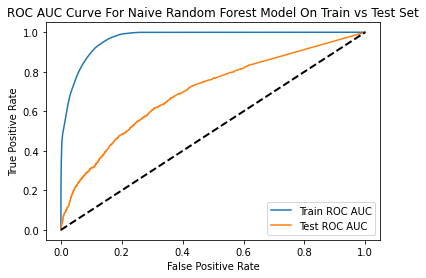

In [11]:
plt.plot(train_fpr, train_tpr, label='Train ROC AUC')
plt.plot(test_fpr, test_tpr, label='Test ROC AUC')
plt.plot([0, 1], [0, 1], color = 'black', linewidth = 2, linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC AUC Curve For Naive Random Forest Model On Train vs Test Set')
plt.show()

This hammers the point home further that this model performs very poorly on data it has not seen before. Thus, we need to dive deeper into what is going on.

###  Random Forest  Hyperparameters

The ``naive_rf_model`` uses the default sklearn Random Forest implementation to build the model, so let's take a lot at that

In [12]:
naive_rf_model

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Here, we see a series of values that are associated with this particular usage of the Random Forest. These values are known as ``hyperparameters`` that help the Random Forest model learn from the data. In this notebook, we will take a closer look at `n_estimators`, `max_depth`, `min_samples_leaf`, `min_samples_split`, `criterion`, and `max_features`. These parameters help with preventing overfitting, but still ensuring that the model learns from the training data.

There are a ton of resources online that will explain the function of these hyperparameters way better than I can, but I will give a brief explanation of them. <br> <br>
`n_estimators`: The number of decision tress used to train the model. Increasing the number of trees will reduce the variance of your predictions as each tree is independent, but increase the amount of time it takes to train the model.  The sklearn default is 100. <br>
`max_depth`: The maximum allowed depth of any individual decision tree. A greater value leads to the model having more splits and learning from the data, but also makes it prone to overfitting. The sklearn default is `None`, which means that the model will keep splitting if it sees the opportunity to improve the `gain`.
`min_samples_leaf`: The minimum number of samples allowed to be in a leaf. The greater the valaue, the less the tree will split, which reduces overfitting but gives the model less opportunity to learn from the data. The sklearn default is 1. <br>
`min_samples_split`: The minimum number of samples allowed to split a leaf into a new leaf. The greater the value, the less likely the tree will split further, which reduces overfitting but gives the model less opportunity to learn from the data. The sklearn default is 2. <br>
`criterion`: The mathematical representation of the "gain" that is used to split nodes. Either `gini` or `entropy`. sklearn defaults to `gini`. <br>
`max_features`: The maximum number of features allowed to use when determining how to split a node. The sklearn default is `auto`, which represents the square  root of the total number of features. The greater the value, the more precise but more prone t overfitting

As you can see, every default `sklearn` parameter (except `n_estimators`) takes on a value that leads to the most extreme overfitting of the data. Thus, you must be really careful when fitting an sklearn (or any machine/deep learning model) to ensure that the hyperparameters are what you want them to be, otherwise your model will perform poorly and you might not understand why.

### Cross Validation  and  Hyper Parameter Tuning

Now, we will go through the process of determining the optimal values of these 6 parameters. There are 3 very common approaches, `RandomSearch`, `GridSearch` and Bayesian methods. @clekraus mentions this in his notebook, but skips over some of the details on the tuning in order to showcasae the results. Thus, I figured this was a good opportunity to explain how to come to the optimal set of hyperparameters.  The optimal parameters will be found using a common machine learning methodology known as `cross_validation`.

Cross validation is a method to ensure that we find the optimal set of parameters to ensure that our model fits the data as well as possible, and is capable of generalizing to new data. The most common form of cross validation is `KFold`. In `KFold`, we split our data into `K` different folds (naturally). We then fit the model `K` times with the relevant hyperparameters. In each run of the model, we use `K-1` folds for training, and then test on the fold that isn't used for training. Thus, we are able to see how our model performs on data it hasn't seen before.

The reason why we fit this `K` times is to ensure that all datapoints are treated equally in training and testing. If we always train on the same data and test on the same data, then we are `overfitting to the test set`.

Now, let's take a look into the methods for determining hyperparameters, as well as their pros and cons. For each method, we determine a "grid" of values for each parameter that  we use to test. Then, each algorithm attempts to pick the best value for each hyparameter:

<b> Random Search: </b> <br> <br>
Description: The user sets a number of iterations to test the model, and then on each iteration the algorithm picks a random set of parameters from the grid (without replacement) and computes the loss metrics. The more iterations, the more likely you are to find the best parameters, but the longer the algorithm takes to run. <br>
Pros: Fastest method out of them all, does a reasonably good job of finding close to the best parameters. Allows for parallelization (which allows you to try multiple sets of parameters at the same time). <br> 
Cons: Setting too few values can lead to suboptimal solutions. Unlikely to find the absolute best set of parameters.

<b> Grid Search: </b> <br> <br>
Description: The algorithm tries every permutation of values from the grid and computes the loss metrics. <br>
Pros: Grid search guarantees that you will find the "optimal" set of hyperparameters, as it tries every single possibility. Like Random Search, it also plays nicely with parallelization. <br>
Cons: By far the slowest out of all the options as it tries every single combination. Thus, you must limit the number of parameters to tune/the number of values for each parameter or else the grid will become massive and you will never finish running your grid search.

<b> Bayesian Search: </b> <br> <br>
Description: In Bayesian Search, the algorithm learns from results of the previous iterations to pick values that are more likely to produce optimal solutions  <br>
Pros: Learns from previous iterations, so converges on the correct solution faster. <br>
Cons: (Generally) doesn't play well with parallelization, so it takes much longer to find the solution. As with all Bayesian methods, there is a risk of converging on a local (rather than global) maximum.  <br>

In this notebook, we will implement both Grid and Random Searches. We won't look at Bayesian because the code is more complicated and due to the lack of parallelization, it is quite slow. In addition, GridSearch is guaranteed to find a "more optimal" solution than Bayesian (as it tries every set of value), albeit in a lot more time.

We will evaluate the performance of these 2 methods on `speed` and `performance`, where `performance` is determined on how the model with the chosen hyperparameters performs on the held out test set (which is not used at all in the cross validation procedure). We use `%timeit` to time the algorithms to illustrate how long they take

Initialize models:

In [13]:
random_search_model = RandomForestClassifier(random_state=42)
grid_search_model = RandomForestClassifier(random_state=42)

Set up the cross validation folds

In [14]:
cv_split = KFold(n_splits=5, random_state=42, shuffle=True)

Set up the grid to pick hyperparameters from:

In [15]:
rf_hyperparam_grid={
    "n_estimators": [100, 500],
    "max_features": ['auto', 7, 10, 15],
    "min_samples_leaf": [1, 5, 20, 100],
    "min_samples_split": [2, 10, 50, 250],
    "criterion": ["gini", "entropy"],
    "max_depth": [4, 6, 8, 10, None]
}

Initialize the Random Search:

In [16]:
rf_random_search=RandomizedSearchCV(
    estimator=random_search_model,
    param_distributions=rf_hyperparam_grid,
    n_iter=150,
    scoring="neg_log_loss",
    refit=True,
    return_train_score=True,
    cv=cv_split,    
    verbose=10,
    n_jobs=-1,
    random_state=42
)

Run the cross validation on the training set

In [17]:
%time tuned_random_model = rf_random_search.fit(x_train, y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   37.4s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   56.1s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  

CPU times: user 16.1 s, sys: 2.39 s, total: 18.5 s
Wall time: 18min 8s


Print out the "optimal" hyperparameters:

In [18]:
tuned_random_model.best_params_

{'n_estimators': 500,
 'min_samples_split': 250,
 'min_samples_leaf': 5,
 'max_features': 7,
 'max_depth': 8,
 'criterion': 'gini'}

See how the model performs on the test  set:

In [19]:
random_y_hat = tuned_random_model.predict_proba(x_test)
print("The log loss of the model with Random Search is: " + str(log_loss(y_test, random_y_hat)))
print("The ROC AUC score of the model with Random Search is: " +str(roc_auc_score(y_test, random_y_hat[:,1])))


The log loss of the model with Random Search is: 0.2781754974949142
The ROC AUC score of the model with Random Search is: 0.7863651712323108


Let's do the same for Grid Search

## This code takes forever to run, so please avoid running the next 4 cells unless you really want to:

In [20]:
rf_grid_search=GridSearchCV(
    estimator=grid_search_model,
    param_grid=rf_hyperparam_grid,
    scoring="neg_log_loss",
    refit=True,
    return_train_score=True,
    cv=cv_split,
    verbose=10,
    n_jobs=-1,
)

In [21]:
%time tuned_grid_model = rf_grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 1280 candidates, totalling 6400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   38.7s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   46.3s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   53.9s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  

CPU times: user 56.6 s, sys: 10.6 s, total: 1min 7s
Wall time: 2h 27min 23s


In [22]:
tuned_grid_model.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 7,
 'min_samples_leaf': 1,
 'min_samples_split': 250,
 'n_estimators': 500}

In [23]:
grid_y_hat = tuned_grid_model.predict_proba(x_test)
print("The log loss of the model with Grid Search is: " + str(log_loss(y_test, grid_y_hat)))
print("The ROC AUC score of the model with Grid Search is: " +str(roc_auc_score(y_test, grid_y_hat[:,1])))

The log loss of the model with Grid Search is: 0.27807799837721187
The ROC AUC score of the model with Grid Search is: 0.7864781218244945


We end up with almost identical parameters (only difference is min_samples_leaf), and we get ever so slightly better performance from the grid search

Let's plot the ROC-AUC curves as well to compare this model to the naive model above

In [24]:
random_fpr, random_tpr, random_thresholds = roc_curve(y_true=y_test, y_score=random_y_hat[:,1])
grid_fpr, grid_tpr, grid_thresholds = roc_curve(y_true=y_test, y_score=grid_y_hat[:,1])

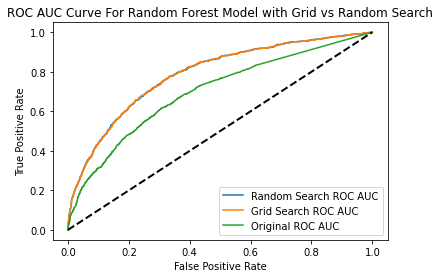

In [25]:
plt.plot(random_fpr, random_tpr, label='Random Search ROC AUC')
plt.plot(grid_fpr, grid_tpr, label='Grid Search ROC AUC')
plt.plot(test_fpr, test_tpr, label='Original ROC AUC')
plt.plot([0, 1], [0, 1], color = 'black', linewidth = 2, linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC AUC Curve For Random Forest Model with Grid vs Random Search')
plt.show()

If we look at our original grid and our fitted hyper-parameters, we found that we reached the edge of the grid for min_samples_split. Thus, we can potentially improve our accuracy by shrinking the parameter grid and fine tuning the model with another Random Search

In [26]:
better_rf_hyperparam_grid={
    "n_estimators": [500],
    "max_features": ["auto", 5, 6, 7, 8],
    "min_samples_leaf": [1,  2, 5, 10, 15, 20],
    "min_samples_split": [100, 200, 250, 300, 400],
    "criterion": ["gini"],
    "max_depth": [6, 7, 8, 9, 10]
}

In [27]:
better_random_search_model = RandomForestClassifier(random_state=42)

In [28]:
better_rf_random_search=RandomizedSearchCV(
    estimator=better_random_search_model,
    param_distributions=better_rf_hyperparam_grid,
    n_iter=250,
    scoring="neg_log_loss",
    refit=True,
    return_train_score=True,
    cv=cv_split,    
    verbose=10,
    n_jobs=-1,
    random_state=42

)

In [29]:
%time better_tuned_random_model = better_rf_random_search.fit(x_train, y_train)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   38.9s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   57.8s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  

CPU times: user 18.4 s, sys: 1.12 s, total: 19.5 s
Wall time: 34min 22s


In [30]:
better_tuned_random_model.best_params_

{'n_estimators': 500,
 'min_samples_split': 300,
 'min_samples_leaf': 1,
 'max_features': 8,
 'max_depth': 8,
 'criterion': 'gini'}

In [31]:
better_random_y_hat = better_tuned_random_model.predict_proba(x_test)
print("The log loss of the model with Random Search is: " + str(log_loss(y_test, better_random_y_hat)))
print("The ROC AUC score of the model with Random Search is: " +str(roc_auc_score(y_test, better_random_y_hat[:,1])))

The log loss of the model with Random Search is: 0.27798832794078215
The ROC AUC score of the model with Random Search is: 0.7867804384791839


We  improve  our log loss  ever  so slightly. However, it appears as though we are getting diminishing marginal returns

#### Partial Dependence Plots For Hyperparameters

Finally, let's take a look at how our accuracy changes as we change each of these parameters on both the training and testing set, to understand more fully how these parameters impact overfitting. In addition, this will help us show how close the Random Search came to determining the "optimal parameters" on a held out dataset (not the test set). To do this, we will create a "validation set" that is a subset of the original training set, so that we are not "overfitting" to our held out test set.

In [32]:
x_train_2, x_val, y_train_2, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [33]:
initial_random_forest_model = RandomForestClassifier(n_estimators=500,
                                                     min_samples_split= 300,
                                                     min_samples_leaf= 1,
                                                     max_features= 8,
                                                     max_depth= 8,
                                                     criterion= 'gini',
                                                     n_jobs=-1)

In [35]:
#n_estimators: 0-1000, increasing by 20 each time
n_estimators_x_axis=np.linspace(20, 800, 40).astype(int)
n_estimators_train_loss=[]
n_estimators_test_loss=[]
for estimators in n_estimators_x_axis:
    model_to_test = initial_random_forest_model.set_params(**{"n_estimators": estimators})
    model_to_test.fit(x_train_2, y_train_2)
    train_predict = model_to_test.predict_proba(x_train_2)
    test_predict = model_to_test.predict_proba(x_val)
    n_estimators_train_loss.append(log_loss(y_train_2, train_predict[:,-1]))
    n_estimators_test_loss.append(log_loss(y_val, test_predict[:,-1]))

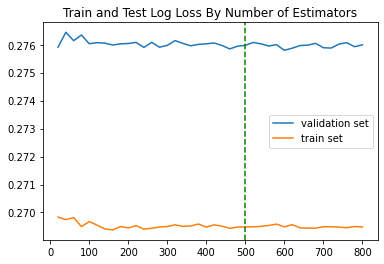

In [36]:
plt.plot(n_estimators_x_axis, n_estimators_test_loss,label='validation set')
plt.plot(n_estimators_x_axis, n_estimators_train_loss,label='train set')
plt.legend()
plt.axvline(x=500, color='green', linestyle='--')
plt.title('Train and Test Log Loss By Number of Estimators')
plt.show()

In [37]:
initial_random_forest_model.set_params(**{"n_estimators": 500})

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features=8,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=300,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [38]:
#Depth: #1-20
max_depth_x_axis=np.linspace(1, 20, 20).astype(int)
max_depth_train_loss=[]
max_depth_test_loss=[]

for depth in max_depth_x_axis:
    model_to_test = initial_random_forest_model.set_params(**{"max_depth": depth})
    model_to_test.fit(x_train_2, y_train_2)
    train_predict = model_to_test.predict_proba(x_train_2)
    test_predict = model_to_test.predict_proba(x_val)
    max_depth_train_loss.append(log_loss(y_train_2, train_predict[:,-1]))
    max_depth_test_loss.append(log_loss(y_val, test_predict[:,-1]))

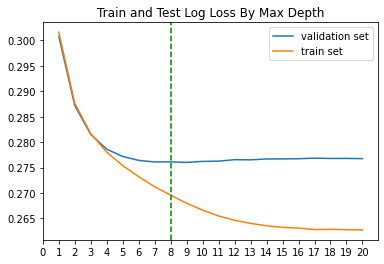

In [39]:
plt.plot(max_depth_x_axis, max_depth_test_loss,label='validation set')
plt.plot(max_depth_x_axis, max_depth_train_loss,label='train set')
plt.legend()
plt.axvline(x=8, color='green', linestyle='--')
plt.xticks(np.arange(21))
plt.title('Train and Test Log Loss By Max Depth')
plt.show()

In [40]:
initial_random_forest_model.set_params(**{"max_depth": 8})

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features=8,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=300,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [41]:
#max_features: 0-18
max_features_x_axis=np.linspace(1, 17, 17).astype(int)
max_features_train_loss=[]
max_features_test_loss=[]

for features in max_features_x_axis:
    model_to_test = initial_random_forest_model.set_params(**{"max_features": features})
    model_to_test.fit(x_train_2, y_train_2)
    train_predict = model_to_test.predict_proba(x_train_2)
    test_predict = model_to_test.predict_proba(x_val)
    max_features_train_loss.append(log_loss(y_train_2, train_predict[:,-1]))
    max_features_test_loss.append(log_loss(y_val, test_predict[:,-1]))

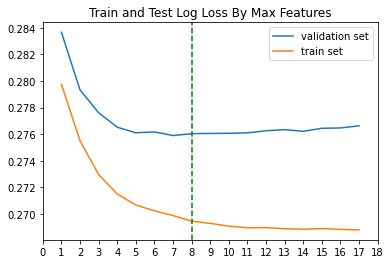

In [42]:
plt.plot(max_features_x_axis, max_features_test_loss,label='validation set')
plt.plot(max_features_x_axis, max_features_train_loss,label='train set')
plt.legend()
plt.axvline(x=8, color='green', linestyle='--')
plt.xticks(np.arange(19))
plt.title('Train and Test Log Loss By Max Features')
plt.show()

In [43]:
initial_random_forest_model.set_params(**{"max_features": 8})

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features=8,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=300,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [44]:
#min_samples_leaf: 1-100, increase by 3:
min_samples_leaf_x_axis=np.linspace(1, 100, 34).astype(int)
min_samples_leaf_train_loss=[]
min_samples_leaf_test_loss=[]

for samples in min_samples_leaf_x_axis:
    model_to_test = initial_random_forest_model.set_params(**{"min_samples_leaf": samples})
    model_to_test.fit(x_train_2, y_train_2)
    train_predict = model_to_test.predict_proba(x_train_2)
    test_predict = model_to_test.predict_proba(x_val)
    min_samples_leaf_train_loss.append(log_loss(y_train_2, train_predict[:,-1]))
    min_samples_leaf_test_loss.append(log_loss(y_val, test_predict[:,-1]))

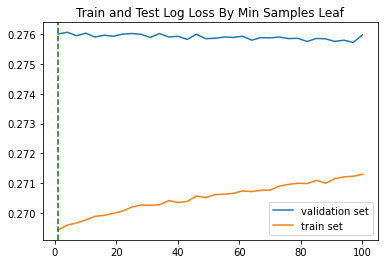

In [45]:
plt.plot(min_samples_leaf_x_axis, min_samples_leaf_test_loss,label='validation set')
plt.plot(min_samples_leaf_x_axis, min_samples_leaf_train_loss,label='train set')
plt.legend()
plt.axvline(x=1, color='green', linestyle='--')
plt.title('Train and Test Log Loss By Min Samples Leaf')
plt.show()

It appears as though this parameter has little effect on the test set predictions of the model

In [46]:
initial_random_forest_model.set_params(**{"min_samples_leaf": 1})

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features=8,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=300,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [47]:
#min_samples_split: 0-500, increasing by 20 each time
min_samples_split_x_axis=np.linspace(25, 600, 25).astype(int)
min_samples_split_train_loss=[]
min_samples_split_test_loss=[]

for samples in min_samples_split_x_axis:
    model_to_test = initial_random_forest_model.set_params(**{"min_samples_split": samples})
    model_to_test.fit(x_train_2, y_train_2)
    train_predict = model_to_test.predict_proba(x_train_2)
    test_predict = model_to_test.predict_proba(x_val)
    min_samples_split_train_loss.append(log_loss(y_train_2, train_predict[:,-1]))
    min_samples_split_test_loss.append(log_loss(y_val, test_predict[:,-1]))

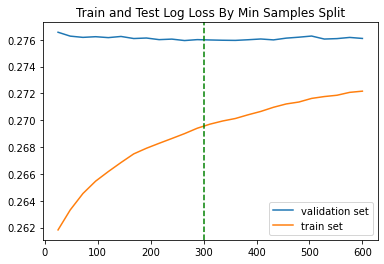

In [48]:
plt.plot(min_samples_split_x_axis, min_samples_split_test_loss,label='validation set')
plt.plot(min_samples_split_x_axis, min_samples_split_train_loss,label='train set')
plt.legend()
plt.axvline(x=300, color='green', linestyle='--')
plt.title('Train and Test Log Loss By Min Samples Split')
plt.show()

In [49]:
initial_random_forest_model.set_params(**{"min_samples_split": 300})

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features=8,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=300,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [50]:
final_rf_model=initial_random_forest_model

In [51]:
final_rf_model.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features=8,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=300,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

### Permutation Importance For Feature Selection

One of the main criticisms of tree based models as that it is relatively uninterpretable and that it is unclear how to determine which features are contributing to your model. ``sklearn`` has a built in feature importance attribute, but I would recommend against using it because it counts the number of splits on each variable. Thus, continuous variables feature more heavily as they have more variables to split on, while categorical variables can only split on 0/1, so the built in  method counts categorical features less. 

Another method for feature importance is by using Shap values, which @clekraus goes into detail on his notebook.

My favorite method for feature importance is permutation importance. The way permutation importance works is on each permutataion, it randomizes the values in columns, re-trains the model, and compares the acacuracy of the predictions between the model with some randomized columns and the original model. The more important a column is, the bigger the disparity between the results of the model with that column randomized and the actual model.

First, we will take a look at the feature importances on the training set. This is  helpful in seeing where the model saw places to split their decision tree.

CPU times: user 6.97 s, sys: 455 ms, total: 7.42 s
Wall time: 5min 46s


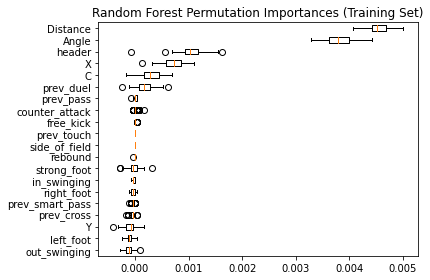

In [52]:
%time  result = permutation_importance(final_rf_model, x_train_2, y_train_2, n_repeats=100, random_state=42, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=x_train.columns[sorted_idx])
ax.set_title("Random Forest Permutation Importances (Training Set)")
fig.tight_layout()
plt.show()

We find that the features that we expected to be criticial are important, notably Distance and angle. We also find that certain features that are perfectly correlated with other features (Y, left_foot  and  out_swinging) were not important in the model, so that is something to keep in mind.

However, we will also run this analysis on the validatoin set so that we know which features are overfit to the training set, as these features would feature prominently when permuted in sample, but hardly (or negatively) feature out of sample

CPU times: user 5.88 s, sys: 368 ms, total: 6.25 s
Wall time: 4min 48s


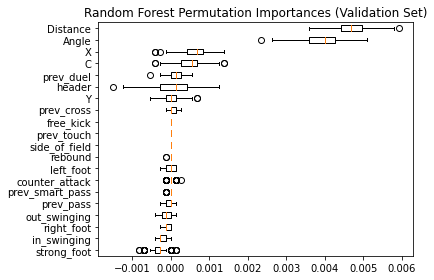

In [53]:
%time  result = permutation_importance(final_rf_model, x_val, y_val, n_repeats=250, random_state=42, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=x_train.columns[sorted_idx])
ax.set_title("Random Forest Permutation Importances (Validation Set)")
fig.tight_layout()
plt.show()

We end up seeing here that many features have 0 (or event negative) effect on the validation set, including some variables that I would have expected to be very important (such as strong foot). This is a fascinating discovery, but also puts into question the quality of this methodology for feature importance.

This is useful as we move to Logistic Regression, as we will compare this output to the "traditional" way of feature selecting as proposed by David Sumpter. We will improve this model during the Logistic regression notebook, taking into knowledge acquired from these plots and variables in the  logistic regression model.